# First `pycausal-explorer` tutorial

`Pycausal-explorer` is a Python module for causal inference and treatment effect estimation. It implements a set of algorithms that supports causal analysis.
<br>To access the source code, please head to our [GitHub homepage](https://github.com/gotolino/pycausal-explorer).
<br><br> In this tutorial, you will learn how to use the libraries main features: **built-in datasets** and a **variety of causal models**. 

If you haven't already downloaded `pycausal-explorer`, you can simply run the next cell:

In [113]:
!pip install pycausal-explorer

You should consider upgrading via the '/Users/heitor.santos/default/bin/python -m pip install --upgrade pip' command.


## Import libraries

In [108]:
from math import sqrt
from time import time

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [91]:
from pycausal_explorer.datasets.ihdp_simulated_outcomes import load_ihdp_simulated_outcomes_dataset
from pycausal_explorer.forests import CausalForestRegressor
from pycausal_explorer.linear import CausalLinearRegression
from pycausal_explorer.meta import SingleLearnerRegressor, TLearnerRegressor, XLearner
from pycausal_explorer.nearest_neighbors import CausalKNNRegressor

## Load data

The dataset we're going to use stems from the [Infant Health and Development Program (IHDP)](https://www.tandfonline.com/doi/suppl/10.1198/jcgs.2010.08162?scroll=top), which from 1985 to 1988 was a collaborative, randomized, longitudinal, multisite clinical trial designed to evaluate the efficacy of comprehensive early intervention in reducing the developmental and health problems of low birth weight, premature infants.
<br><br>
While the covariates are actual data from participants of the program, treatment outcomes were simulated as functions of such covariates, as described in [HILL, 2011](https://www.tandfonline.com/doi/abs/10.1198/jcgs.2010.08162):
- Simulation A (column `y_A_sim`) is a linear surfance (i.e. treatment effect is a linear function of the covariates)
- Simulation B (column `y_B_sim`) is a non-linear surfance (i.e. treatment effect is a complex, non-linear function of the covariates)

<br><br>
In both simulations, the average treatment effect was made to be equals to 4, so: $ATE_{actual} = 4.0$

In [101]:
df = load_ihdp_simulated_outcomes_dataset()

In [7]:
df.head()

,treat,bw,b.head,preterm,birth.o,nnhealth,momage,sex,twin,b.marr,...,prenatal,ark,ein,har,mia,pen,tex,was,y_A_sim,y_B_sim
0,1,1559,28.648521,10,2,94,33,1,0,1,...,1,1,0,0,0,0,0,0,13.078092,16.992303
1,0,1000,25.000000,8,4,89,33,0,0,0,...,1,1,0,0,0,0,0,0,14.733734,15.069412
2,0,1430,29.000000,6,1,112,22,0,0,0,...,1,1,0,0,0,0,0,0,6.252329,11.658046
3,0,1984,31.000000,2,1,99,20,0,0,0,...,1,1,0,0,0,0,0,0,14.352013,20.395858
4,0,1320,28.000000,7,2,110,23,1,0,0,...,1,1,0,0,0,0,0,0,12.070612,16.628788


In [8]:
df.shape

(747, 28)

Now, let us define the main variables in our study:
- The treatment flag (i.e. whether the individual has participated in the IHDP or not) is informed by the column `treat` ($W$)
- We will estimate the more complex non-linear treatment effect form simulation B (`y_B_sim`), so that will be our outcome ($Y$)
- All remaining columns will be used as covariates ($X$)

In [63]:
treatment = 'treat'

covariates = [
    'bw', 'b.head', 'preterm', 'birth.o', 'nnhealth', 'momage',
    'sex', 'twin', 'b.marr', 'mom.lths', 'mom.hs', 'mom.scoll', 'cig',
    'first', 'booze', 'drugs', 'work.dur', 'prenatal', 
    'ark', 'ein', 'har',
    'mia', 'pen', 'tex', 'was',
]

outcome = 'y_B_sim'

## EDA

### Treatment assignment

Only 139 individuals (18.6%) were treated.

In [64]:
df[treatment].value_counts()

0    608
1    139
Name: treat, dtype: int64

### Correlation map

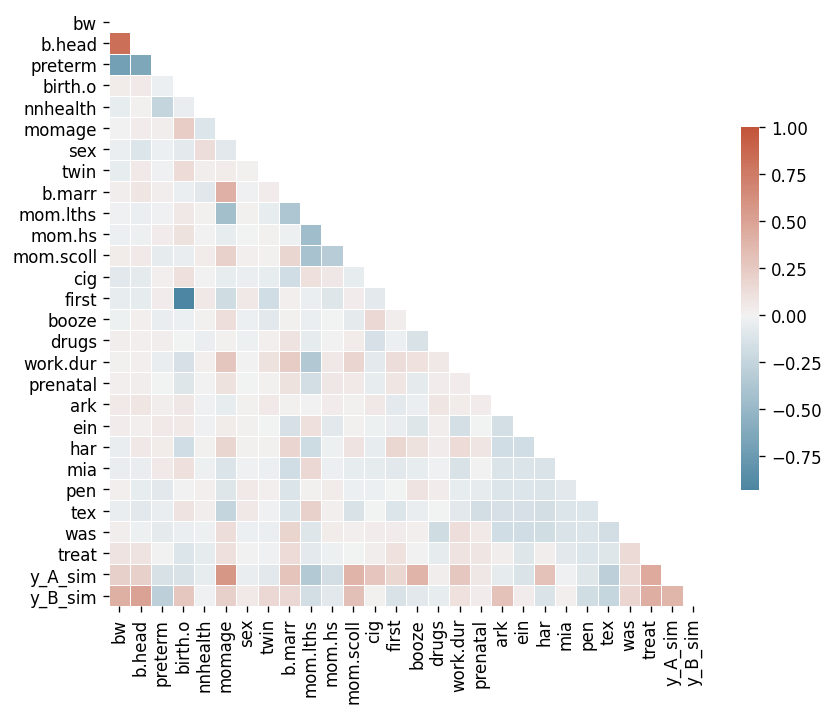

In [104]:
# Compute the correlation matrix
corr = df[covariates + [treatment, 'y_A_sim', 'y_B_sim']].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8), dpi=120)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Compute causal effects

Now, we will experiment with causal estimation using different causal algorithms, from the baseline ones (e.g. linear regression, k-nearest neighbors) to the more advanced ones, like forests and metalearners.
<br><br>
Let us first split our dataset into train and test sets to compare all algorithms fairly.

In [105]:
X_train, X_test, w_train, w_test, y_train, y_test = train_test_split(
    df[covariates], 
    df[treatment],
    df[outcome], 
    test_size=0.33, 
    stratify=df[treatment],
    random_state=42
)

### Naïve average treatment effect

The simplest thing we could try to compute the average treatment effect is to subtract the mean outcome for treated individuals and the mean outcome for control individuals, which can be expressed as: 
<br>
$ATE_{naïve} = E[Y|W=1] - E[Y|W=0] = mean(Y)_{treated} - mean(Y)_{control}$

In [69]:
y_test[w_test == 1].mean() - y_test[w_test == 0].mean()

4.16977936965492

By perfomring this very simple calculation, we get that $ATE_{naïve} = 4.17$ for the test set, which is not very far from the true value $ATE_{actual} = 4.0$. Let's see how each model performs in this task!

### Benchmark of causal models

We are benchmarking the following causal regression models:
- Linear regression;
- K-nearest neighbors;
- Causal forest;
- Metalearners (S-learner, T-learner and X-learner) with random forests as underlying algorithms.

In [109]:
models = [
    CausalLinearRegression(),
    CausalKNNRegressor(),
    CausalForestRegressor(),
    SingleLearnerRegressor(learner=RandomForestRegressor(n_estimators=100)),
    TLearnerRegressor(
        treatment_learner=RandomForestRegressor(n_estimators=100), 
        control_learner=RandomForestRegressor(n_estimators=100)
    ),
    XLearner(
        learner=None,
        u0=RandomForestRegressor(n_estimators=100),
        u1=RandomForestRegressor(n_estimators=100),
        te_u0=RandomForestRegressor(n_estimators=100),
        te_u1=RandomForestRegressor(n_estimators=100)
    ),
]

model_names = [
    'Linear regression', 
    'K-nearest neighbors', 
    'Causal forest',
    'S-learner', 
    'T-learner',
    'X-learner'
]

We are tracking the following performance metrics:
- Predicted ATE;
- Absolute percentage error of the predicted ATE in comparison to the actual ATE;
- Mean absolute percentage error of Y (individual outcomes) prediction;
- Elapsed time to train and make predictions with each model.

In [110]:
data = []
trained_models = {}
for model, name in zip(models, model_names):
    r0 = model
    
    start_time = time()
    r0.fit(X=X_train, treatment=w_train, y=y_train)
    y_pred = r0.predict(X_test, w=w_test)
    ate = r0.predict_ate(X_test)
    end_time = time()

    y_pred = np.array(y_pred, dtype=np.float64)

    data.append(
        {
            'Model': name,
            'Predicted ATE': ate,
            'Absolute ATE percentage error': abs(ate - 4) / 4,
            'Mean absolute percentage error (Y)': mean_absolute_percentage_error(y_test, np.nan_to_num(y_pred)),
            'Elapsed time': round(end_time - start_time, 2)
        }
    )
    
    trained_models[name] = r0
benchmark_results = pd.DataFrame(data)

Let's see how their performances compare:

In [111]:
benchmark_results

,Model,Predicted ATE,Absolute ATE percentage error,Mean absolute percentage error (Y),Elapsed time
0,Linear regression,3.557582,0.110604,1.236126e-01,0.02
1,K-nearest neighbors,4.419259,0.104815,1.640600e-01,0.03
2,Causal forest,4.087617,0.021904,1.427519e-01,10.44
3,S-learner,4.321924,0.080481,1.211756e-01,0.30
4,T-learner,3.869273,0.032682,8.546062e+19,0.41
5,X-learner,3.777390,0.055652,2.516144e+302,0.82


**Causal forest** is the best model in terms of absolute ATE percentage error (i.e. its ATE is the closest to the actual value), while it also had a decent performance at predicting the outcomes themselves. 
<br><br>
It's interesting to note that, while the more complex metalearners (T-learner and X-learner) came second and third in terms of the ATE percentage error, their outcome prediction error is going through the roof as it is not their specialty. **These algorithms intentionally compromise on the ability of accurately predicting $Y$ for the sake of predicting the ATE well**.

### Visualize results

Let's see the **distribution of individual treatment effects (ITE)** predicted by the causal forest and the metalearners.

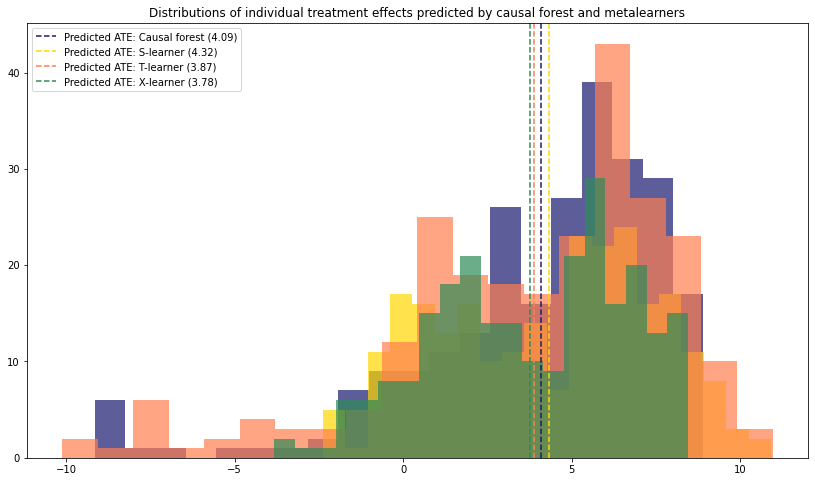

In [115]:
plt.figure(figsize=(14, 8))
plt.title('Distributions of individual treatment effects predicted by causal forest and metalearners')

# Causal forest
plt.hist(
    trained_models['Causal forest'].predict_ite(X_test), 
    bins=20,
    alpha=0.7,
    color='midnightblue'
)
plt.axvline(
    trained_models['Causal forest'].predict_ate(X_test), 
    linestyle='--',
    label='Predicted ATE: Causal forest ({})'.format(round(trained_models['Causal forest'].predict_ate(X_test), 2)),
    color='midnightblue'
)

# S-learner
plt.hist(
    trained_models['S-learner'].predict_ite(X_test), 
    bins=20,
    alpha=0.7,
    color='gold'
)
plt.axvline(
    trained_models['S-learner'].predict_ate(X_test), 
    linestyle='--',
    label='Predicted ATE: S-learner ({})'.format(round(trained_models['S-learner'].predict_ate(X_test), 2)),
    color='gold'
)

# T-learner
plt.hist(
    trained_models['T-learner'].predict_ite(X_test), 
    bins=20,
    alpha=0.7,
    color='coral'
)
plt.axvline(
    trained_models['T-learner'].predict_ate(X_test), 
    linestyle='--',
    label='Predicted ATE: T-learner ({})'.format(round(trained_models['T-learner'].predict_ate(X_test), 2)),
    color='coral'
)

# X-learner
plt.hist(
    trained_models['X-learner'].predict_ite(X_test), 
    bins=20,
    alpha=0.7,
    color='seagreen'
)
plt.axvline(
    trained_models['X-learner'].predict_ate(X_test), 
    linestyle='--',
    label='Predicted ATE: X-learner ({})'.format(round(trained_models['X-learner'].predict_ate(X_test), 2)),
    color='seagreen'
)
plt.legend()
plt.show()

Not much difference between them, right? Overall, all models seem to predict ITE in pretty much the same ranges.

Now, let's dive deeper into causal forest's results, as it was the best model. First, **let's visualize individual treatment effects using a partial dependence plot**:

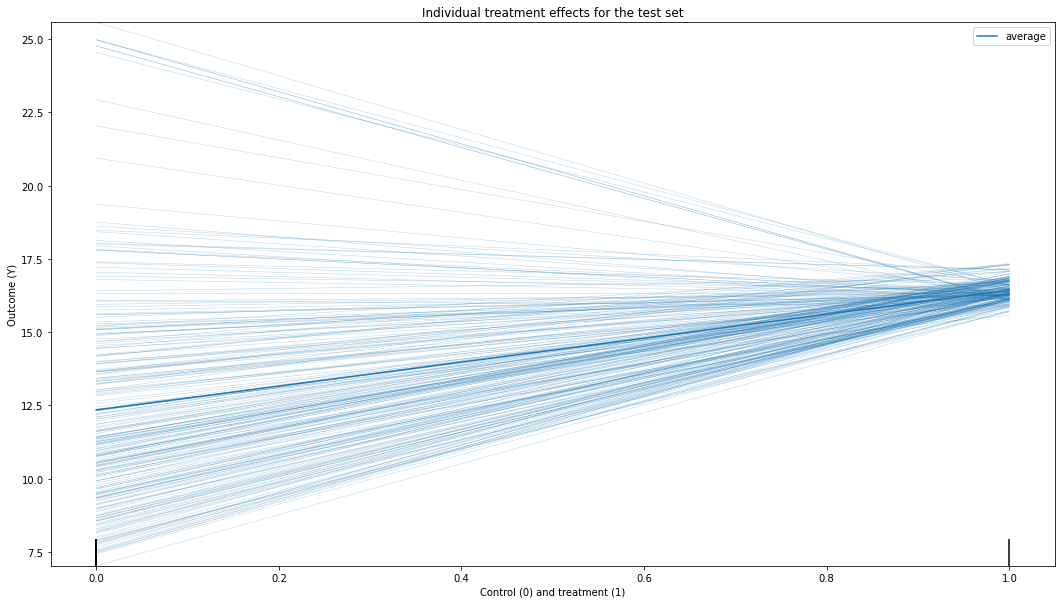

In [123]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.set_title('Individual treatment effects for the test set')
pdp = plot_partial_dependence(  
    estimator=trained_models['Causal forest'], 
    X=X_test.assign(treat=w_test), 
    features=[treatment],
    kind='both',
    ax=ax
    # subsample=0.6
)
plt.xlabel('Control (0) and treatment (1)')
plt.ylabel('Outcome (Y)')
plt.show()

It's interesting to see that, even though the average treatment effect is positive and equals to 4, **individual treatment effects vary a lot and can even be negative in some cases**.

Finally, **let's see a contour plot to check how the treatment effect varies according to the covariates**. For the sake of visualization, we pick the 2 most important model features and plot treatment effects over them.

In [124]:
# Get model's 2 most important features
model_feat_importances = pd.DataFrame(
    columns=['feature', 'importance']
)

model_feat_importances['feature'] = covariates
model_feat_importances['importance'] = trained_models['Causal forest'].feature_importances_

top_2_features = model_feat_importances.sort_values(
    'importance',
    ascending=False
)['feature'].head(2).values.tolist()

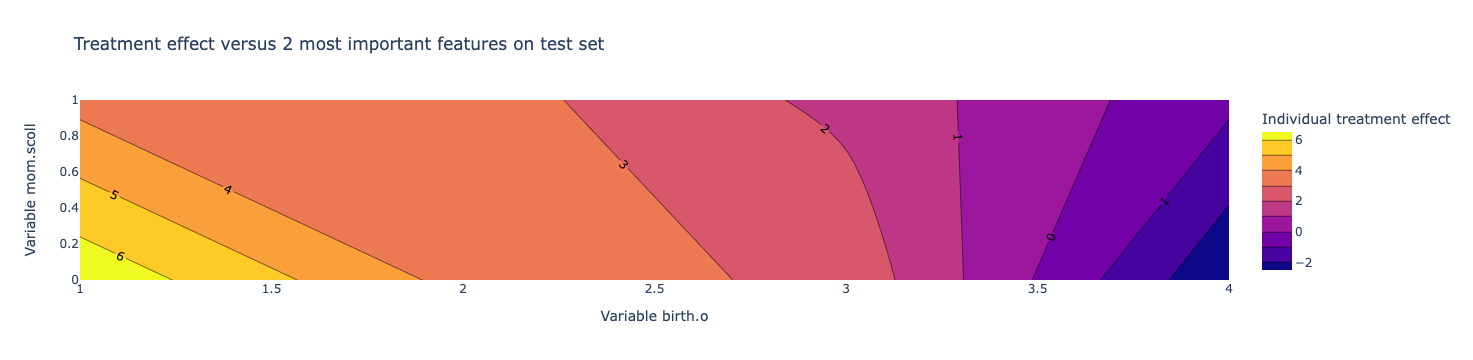

In [125]:
# Make contour plot
fig = go.Figure(
    data=go.Contour(
        z=trained_models['Causal forest'].predict_ite(X_test),
        x=X_test[top_2_features[0]], # horizontal axis
        y=X_test[top_2_features[1]], # vertical axis
        colorbar={"title": 'Individual treatment effect'}
    )
)

fig.update_layout(
    title=" Treatment effect versus 2 most important features on test set",
    xaxis_title=f"Variable {top_2_features[0]}",
    yaxis_title=f"Variable {top_2_features[1]}",
    legend_title="Individual treatment effect",
    # font=dict(
    #     family="Courier New, monospace",
    #     size=18,
    #     color="RebeccaPurple"
    # )
)

fig.update_traces(
    contours_coloring="fill", 
    contours_showlabels=True
)

Wow! We can see that the 2 most important features are `mom.scoll` (whether mothers went to school or not) and `birth.o` (birth order within the family of the child in the dataset). We can see that **the treatment yields stronger outcomes (> 6.0) for unschooled moms having their first child**, while **it is even negative for unschooled moms on their third or fourth child**.

**...and that's a wrap!** We hope you had as much fun as we did building this, and please feel free to experiment with `pycausal-explorer` on your own projects and give us your feedback. Stay curious! 👋🏻